In [3]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# choose_whole_grains

## Data Preprocessing

In [4]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'choose_whole_grain_carbs')

In [5]:
df['meal_ingredients'].isnull().sum()

4

In [6]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [7]:
df['meal_ingredients'].isnull().sum()

0

In [8]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [12]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 699
Total negative labels: 554
Total positive labels: 145


# TFIDF


## Meal Ingredients

In [13]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [14]:
df['meal_ingredients']

0                                    Turkey burger salad
1                                          Chicken salad
2                                     Salad sweet potato
3                                              Bagel egg
4                                     Boiling egg coffee
                             ...                        
698    Chicken patty, wholewheat wrap ,mozzarella cheese
699    Bowl oatmeal, 2 x hard-boiled egg 16 oz bottle...
700                                              Oatmeal
701    Whiting fish sandwich 1 x tablespoon tartar ho...
702    Bowl Minestrone soup, 2 x slice whole wheat br...
Name: meal_ingredients, Length: 699, dtype: object

In [15]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [16]:
document

['Turkey burger salad',
 'Chicken salad',
 'Salad sweet potato',
 'Bagel egg',
 'Boiling egg coffee',
 'Lentil soup',
 'Pepper onion tomato onion omelette',
 'Boiling egg',
 'Quinoa vegetable',
 'Lima beans, smoke neckbones, rice',
 'Eggs, grit, corn beef hash, English muffin ,tea',
 'Chicken cabbage',
 'Eggs, bologna ham,salami,English muffins, tea',
 'Chop cheese burger seasoned French fry',
 'Beef carrot celery onions. Peas',
 'Lentils carrot onion',
 'Eggs cheese onion. Orange, water coffee',
 'Bacon lettuce tomato mayo bread coffee wAter',
 'Cheerios. Almond milk...unsweetened grape coffee',
 '2 x ham/Swiss rapps, small potato salad 16 oz bottle water.',
 'Stuffed shells, mixed salad 16 oz bottle water.',
 'Yellow rice corned beef, banana cup black coffee 2 tspn raw sugar.',
 'Egg cheese roll, banana cup black coffee 2 tspn sugar.',
 'BBQ rib yellow rice Gandules olives. Mixed salad: baby spinach greens, cucumber cherry tomato olive oil dressing.',
 'White rice, red bean steak oni

In [17]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [19]:
print(X_train.shape, X_test.shape)

(559,) (140,)


In [20]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


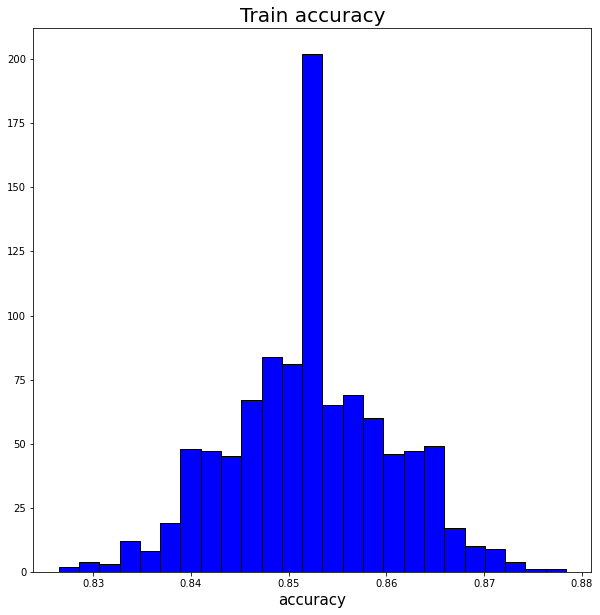

In [21]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [22]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.852144901610018
0.008199214853213198


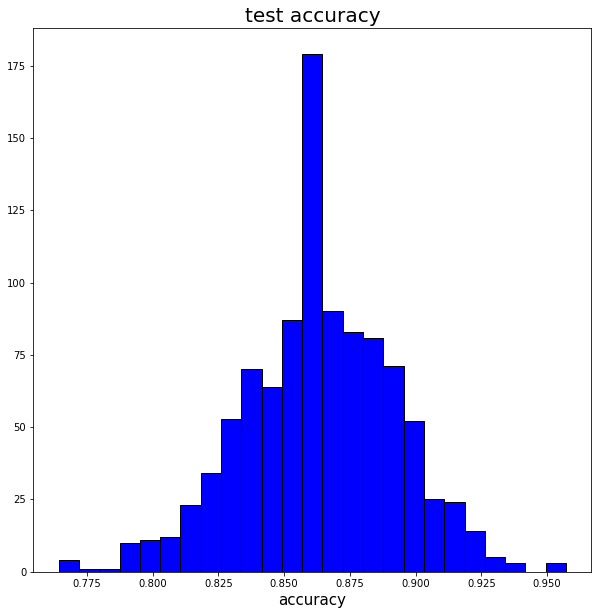

In [23]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [24]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8632142857142857
0.02958859060309482


# TFIDF Meal Title

In [25]:
df['meal_title'].isnull().sum()

1

In [26]:
df['meal_title'] = df['meal_title'].astype(str)

In [27]:
df = df.dropna(axis=0, subset=['meal_title'])

In [28]:
df['meal_title'].isnull().sum()

0

In [29]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [30]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [32]:
print(X_train.shape, X_test.shape)

(559,) (140,)


In [33]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

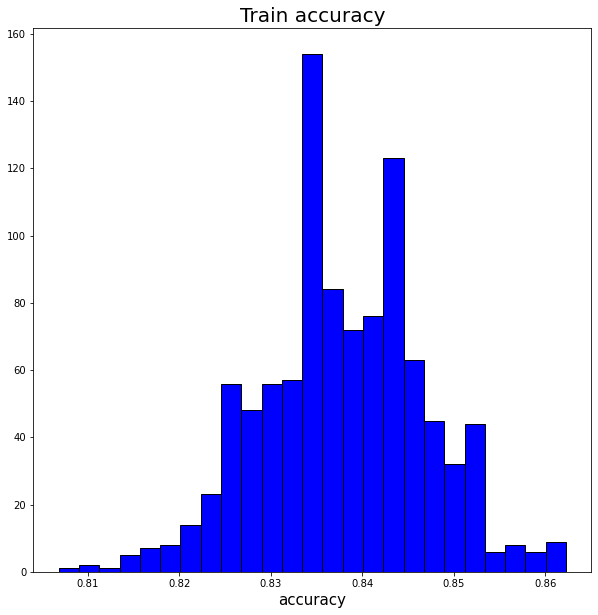

In [34]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [35]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8378282647584974
0.008951389866648481


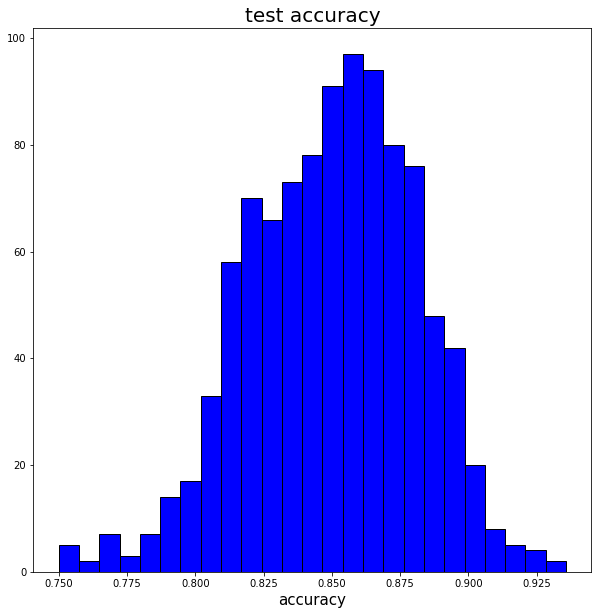

In [36]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [37]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8496428571428571
0.02954545097759362


# TFIDF Ingredients + Title

In [38]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [39]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [40]:
document

['Turkey burger salad Salad with turkey burger',
 'Chicken salad Chicken with mixed vegetables',
 'Salad sweet potato Salad ,sweet potatoes and avocado',
 'Bagel egg 1/2bagel with one egg',
 'Boiling egg coffee Coffee and egg',
 'Lentil soup Lentil soup',
 'Pepper onion tomato onion omelette Vegetables omelette',
 'Boiling egg Boiling eggs with one cracker',
 'Quinoa vegetable Quinoa and vegetables',
 'Lima beans, smoke neckbones, rice Lima beans, smoke  neckbones rice',
 'Eggs, grit, corn beef hash, English muffin ,tea Eggs grit, corn beef hash,English muffins, tea,',
 'Chicken cabbage Chicken and cabbage',
 'Eggs, bologna ham,salami,English muffins, tea Omelet',
 'Chop cheese burger seasoned French fry All American meal',
 'Beef carrot celery onions. Peas Mo mos stew',
 'Lentils carrot onion Yummy yummy lentils lentils',
 'Eggs cheese onion. Orange, water coffee Fast and easy breezy',
 'Bacon lettuce tomato mayo bread coffee wAter Blt and coffee',
 'Cheerios. Almond milk...unsweetene

In [41]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [43]:
print(X_train.shape, X_test.shape)

(559,) (140,)


In [44]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


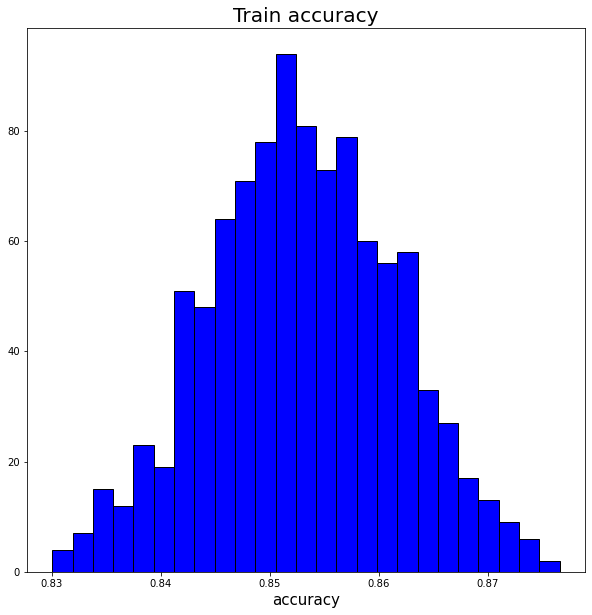

In [45]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [46]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8529159212880144
0.008245608151935839


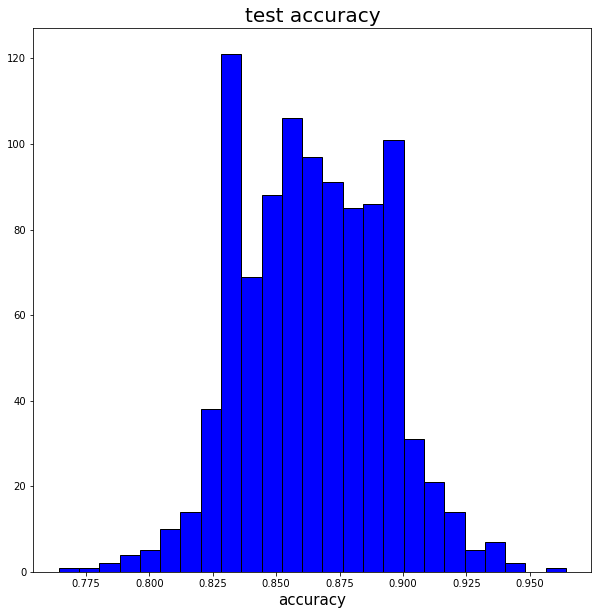

In [47]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [48]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8643214285714287
0.02799870168272749


# Word2vec

## ingredients

In [49]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [50]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [51]:
meal_ingredients

0                                [turkey, burger, salad]
1                                       [chicken, salad]
2                                 [salad, sweet, potato]
3                                           [bagel, egg]
4                                 [boiling, egg, coffee]
                             ...                        
698    [chicken, patty, wholewheat, wrap, mozzarella,...
699    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
700                                            [oatmeal]
701    [whiting, fish, sandwich, tablespoon, tartar, ...
702    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: meal_ingredients, Length: 699, dtype: object

In [52]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [53]:
learned_words_meal_ingredients

['water',
 'oz',
 'cheese',
 'rice',
 'chicken',
 'bottle',
 'tomato',
 'bread',
 'salad',
 'egg',
 'onion',
 'cup',
 'banana',
 'whole',
 'wheat',
 'pepper',
 'coffee',
 'lettuce',
 'milk',
 'corn',
 'sauce',
 'black',
 'spinach',
 'red',
 'potato',
 'beans',
 'broccoli',
 'yellow',
 'sugar',
 'white',
 'turkey',
 'beef',
 'green',
 'mixed',
 'bean',
 'sandwich',
 'orange',
 'carrots',
 'cucumber',
 'soup',
 'eggs',
 'cereal',
 'pork',
 'yogurt',
 'onions',
 'fish',
 'vegetable',
 'olive',
 'boiled',
 'butter',
 'mango',
 'hot',
 'oil',
 'apple',
 'tspn',
 'steak',
 'carrot',
 'oatmeal',
 'bacon',
 'fried',
 'slice',
 'ham',
 'hard',
 'cabbage',
 'cherry',
 'sweet',
 'leche',
 'avocado',
 'sausage',
 'tortilla',
 'salt',
 'integral',
 'pasta',
 'grain',
 'garlic',
 'bun',
 'chatney',
 'tea',
 'pea',
 'roast',
 'brown',
 'strawberry',
 'raw',
 'peppers',
 'chocolate',
 'tuna',
 'tomatoes',
 'breast',
 'juice',
 'potatoes',
 'roll',
 'bbq',
 'ketchup',
 'fry',
 'huevo',
 'pineapple',
 '

In [54]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [55]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [56]:
data_y = np.squeeze(data_y)
data_y.shape

(699,)

In [57]:
data_X = pd.DataFrame(l)
data_X.shape

(699, 100)

In [58]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

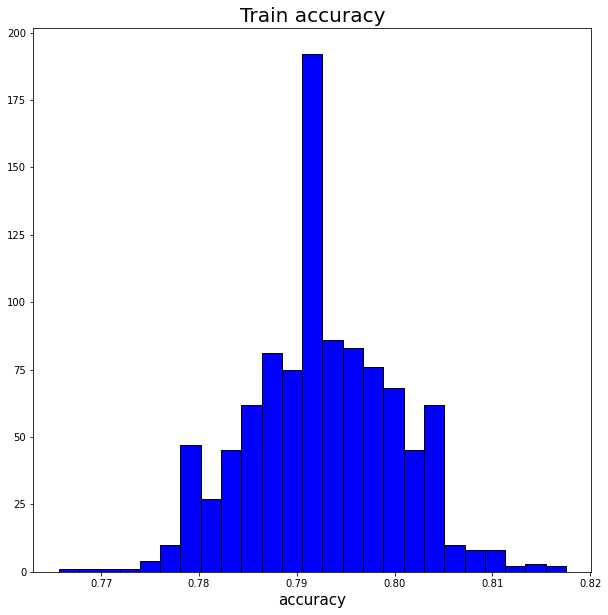

In [59]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [60]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7925760286225402
0.007537549623782477


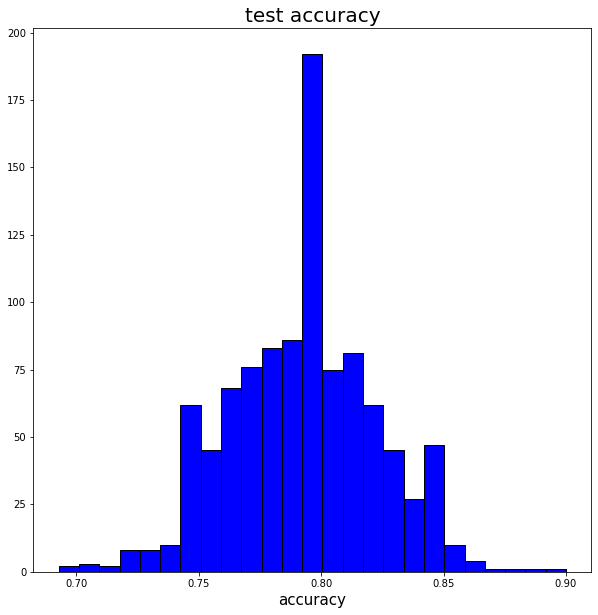

In [61]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [62]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7925000000000001
0.03009635885496003


## title

In [63]:
df['meal_title'].isnull().sum()

0

In [64]:
df['meal_title'] = df['meal_title'].astype(str)

In [65]:
df = df.dropna(axis=0, subset=['meal_title'])

In [66]:
df['meal_title'].isnull().sum()

0

In [67]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [68]:
meal_title

0                          [salad, with, turkey, burger]
1                     [chicken, with, mixed, vegetables]
2                 [salad, sweet, potatoes, and, avocado]
3                                [bagel, with, one, egg]
4                                     [coffee, and, egg]
                             ...                        
698          [chicken, parmesan, with, wholewheat, wrap]
699    [bowl, of, oatmeal, hard, boiled, eggs, and, b...
700                                             [cereal]
701    [whiting, fish, sandwich, and, bottle, of, water]
702    [minestrone, soup, whole, wheat, bread, and, w...
Name: meal_title, Length: 699, dtype: object

In [69]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [70]:
learned_words_meal_title

['and',
 'of',
 'water',
 'with',
 'salad',
 'chicken',
 'rice',
 'bottle',
 'cheese',
 'eggs',
 'banana',
 'coffee',
 'sandwich',
 'whole',
 'beans',
 'bread',
 'yellow',
 'cereal',
 'cup',
 'orange',
 'wheat',
 'soup',
 'mixed',
 'fish',
 'lunch',
 'yogurt',
 'black',
 'dinner',
 'breakfast',
 'boiled',
 'mango',
 'egg',
 'steak',
 'beef',
 'milk',
 'red',
 'grain',
 'fries',
 'hard',
 'potato',
 'chatney',
 'oatmeal',
 'turkey',
 'apple',
 'pork',
 'grapes',
 'onions',
 'vegetables',
 'ribs',
 'oz',
 'broccoli',
 'juice',
 'tomato',
 'meatballs',
 'fruit',
 'potatoes',
 'burrito',
 'sausage',
 'tuna',
 'cabbage',
 'integral',
 'sweet',
 'on',
 'tortillas',
 'breast',
 'carrots',
 'pasta',
 'bacon',
 'white',
 'lettuce',
 'huevo',
 'ham',
 'corn',
 'bar',
 'bbq',
 'pan',
 'veggies',
 'con',
 'spaghetti',
 'pizza',
 'ginger',
 'fried',
 'food',
 'smoothie',
 'roast',
 'mac',
 'raisin',
 'chocolate',
 'butter',
 'peas',
 'smoke',
 'roll',
 'burger',
 'baked',
 'stew',
 'arroz',
 'shrim

In [71]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [72]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [73]:
data_y = np.squeeze(data_y)
data_y.shape

(699,)

In [74]:
data_X = pd.DataFrame(l)
data_X.shape

(699, 100)

In [75]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

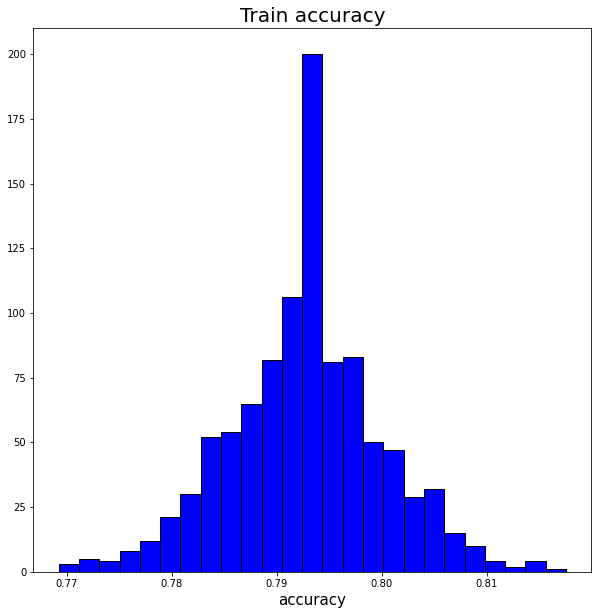

In [76]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [77]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7926833631484794
0.007397500061428543


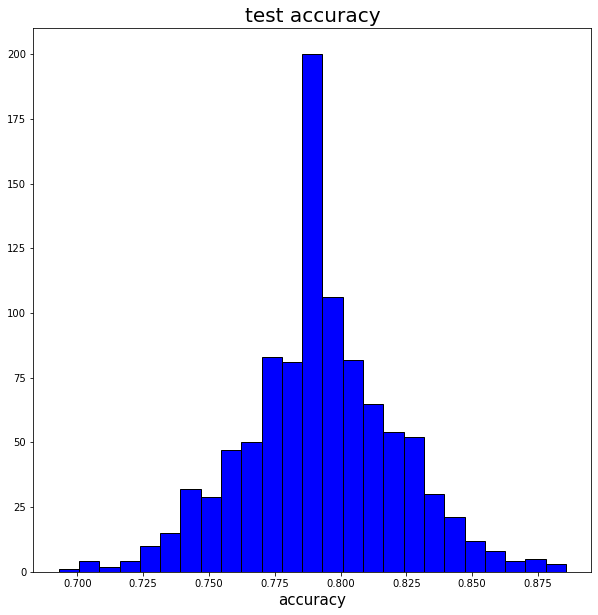

In [78]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [79]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7920714285714286
0.029537160959561104


## ingredients_and_title

In [80]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [81]:
df['ingredients_and_title']

0           Turkey burger salad Salad with turkey burger
1            Chicken salad Chicken with mixed vegetables
2      Salad sweet potato Salad ,sweet potatoes and a...
3                        Bagel egg 1/2bagel with one egg
4                      Boiling egg coffee Coffee and egg
                             ...                        
698    Chicken patty, wholewheat wrap ,mozzarella che...
699    Bowl oatmeal, 2 x hard-boiled egg 16 oz bottle...
700                                       Oatmeal Cereal
701    Whiting fish sandwich 1 x tablespoon tartar ho...
702    Bowl Minestrone soup, 2 x slice whole wheat br...
Name: ingredients_and_title, Length: 699, dtype: object

In [82]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [83]:
meal_ingredients_title

0      [turkey, burger, salad, salad, with, turkey, b...
1      [chicken, salad, chicken, with, mixed, vegetab...
2      [salad, sweet, potato, salad, sweet, potatoes,...
3                    [bagel, egg, bagel, with, one, egg]
4               [boiling, egg, coffee, coffee, and, egg]
                             ...                        
698    [chicken, patty, wholewheat, wrap, mozzarella,...
699    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
700                                    [oatmeal, cereal]
701    [whiting, fish, sandwich, tablespoon, tartar, ...
702    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: ingredients_and_title, Length: 699, dtype: object

In [84]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [85]:
learned_words_meal_ingredients_title

['and',
 'water',
 'rice',
 'chicken',
 'cheese',
 'bottle',
 'salad',
 'of',
 'oz',
 'bread',
 'with',
 'banana',
 'whole',
 'tomato',
 'egg',
 'coffee',
 'cup',
 'wheat',
 'eggs',
 'beans',
 'sandwich',
 'milk',
 'onion',
 'yellow',
 'black',
 'lettuce',
 'red',
 'pepper',
 'cereal',
 'orange',
 'mixed',
 'potato',
 'soup',
 'beef',
 'corn',
 'turkey',
 'broccoli',
 'yogurt',
 'sauce',
 'fish',
 'spinach',
 'white',
 'boiled',
 'sugar',
 'mango',
 'pork',
 'carrots',
 'steak',
 'onions',
 'green',
 'apple',
 'oatmeal',
 'hard',
 'grain',
 'bean',
 'chatney',
 'ham',
 'bacon',
 'cabbage',
 'butter',
 'fried',
 'vegetable',
 'sweet',
 'sausage',
 'cucumber',
 'integral',
 'pasta',
 'juice',
 'potatoes',
 'breast',
 'tuna',
 'lunch',
 'dinner',
 'burrito',
 'fruit',
 'hot',
 'breakfast',
 'avocado',
 'olive',
 'roast',
 'huevo',
 'fries',
 'chocolate',
 'bbq',
 'leche',
 'ribs',
 'grapes',
 'peppers',
 'pan',
 'tspn',
 'oil',
 'carrot',
 'tea',
 'roll',
 'brown',
 'slice',
 'raisin',
 '

In [86]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [87]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [88]:
data_y = np.squeeze(data_y)
data_y.shape

(699,)

In [89]:
data_X = pd.DataFrame(l)
data_X.shape

(699, 100)

In [90]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

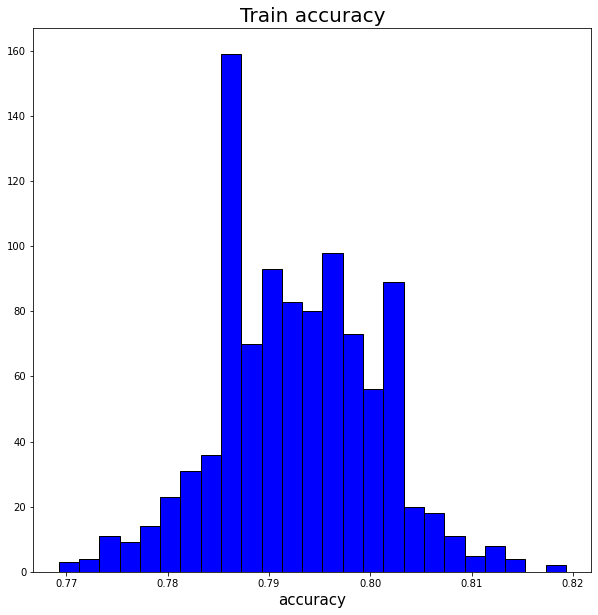

In [91]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [92]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.7926797853309481
0.0078496892646391


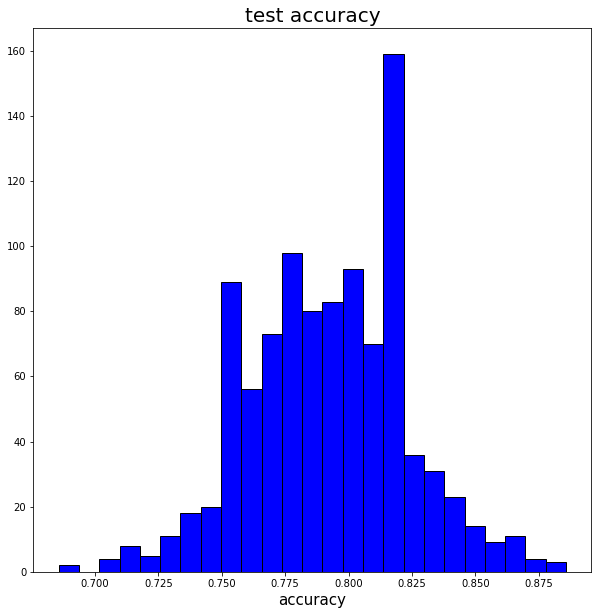

In [93]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [94]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.7920857142857143
0.031342687849523265
